In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geovoronoi import coords_to_points, points_to_coords, voronoi_regions_from_coords, calculate_polygon_areas,assign_points_to_voronoi_polygons
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
pd.options.mode.chained_assignment = None
import matplotlib.style
import matplotlib as mpl
import logging
import pyproj
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
import re



In [8]:
census_counties = pd.read_csv("data/PEP_2016_PEPANNRES_with_ann.csv", encoding='latin-1')
print(census_counties)

for i,county in enumerate(census_counties["GEO.display-label"][:10]):
    m = re.split(r' County',county)
    print(m[0])

              GEO.id GEO.id2             GEO.display-label  \
0                 Id     Id2                     Geography   
1     0500000US01001   01001       Autauga County, Alabama   
2     0500000US01003   01003       Baldwin County, Alabama   
3     0500000US01005   01005       Barbour County, Alabama   
4     0500000US01007   01007          Bibb County, Alabama   
5     0500000US01009   01009        Blount County, Alabama   
6     0500000US01011   01011       Bullock County, Alabama   
7     0500000US01013   01013        Butler County, Alabama   
8     0500000US01015   01015       Calhoun County, Alabama   
9     0500000US01017   01017      Chambers County, Alabama   
10    0500000US01019   01019      Cherokee County, Alabama   
11    0500000US01021   01021       Chilton County, Alabama   
12    0500000US01023   01023       Choctaw County, Alabama   
13    0500000US01025   01025        Clarke County, Alabama   
14    0500000US01027   01027          Clay County, Alabama   
15    05

In [9]:
census_counties

,GEO.id,GEO.id2,GEO.display-label,rescen42010,resbase42010,respop72010,respop72011,respop72012,respop72013,respop72014,respop72015,respop72016
0,Id,Id2,Geography,"April 1, 2010 - Census","April 1, 2010 - Estimates Base",Population Estimate (as of July 1) - 2010,Population Estimate (as of July 1) - 2011,Population Estimate (as of July 1) - 2012,Population Estimate (as of July 1) - 2013,Population Estimate (as of July 1) - 2014,Population Estimate (as of July 1) - 2015,Population Estimate (as of July 1) - 2016
1,0500000US01001,01001,"Autauga County, Alabama",54571,54571,54742,55255,55027,54792,54977,55035,55416
2,0500000US01003,01003,"Baldwin County, Alabama",182265,182265,183199,186653,190403,195147,199745,203690,208563
3,0500000US01005,01005,"Barbour County, Alabama",27457,27457,27348,27326,27132,26938,26763,26270,25965
4,0500000US01007,01007,"Bibb County, Alabama",22915,22919,22861,22736,22645,22501,22511,22561,22643
5,0500000US01009,01009,"Blount County, Alabama",57322,57324,57376,57707,57772,57746,57621,57676,57704
6,0500000US01011,01011,"Bullock County, Alabama",10914,10911,10892,10722,10654,10576,10712,10455,10362
7,0500000US01013,01013,"Butler County, Alabama",20947,20946,20938,20848,20665,20330,20283,20126,19998
8,0500000US01015,01015,"Calhoun County, Alabama",118572,118586,118468,117736,117208,116475,115837,115285,114611
9,0500000US01017,01017,"Chambers County, Alabama",34215,34170,34101,34006,34084,34123,33996,34043,33843


In [10]:
life_expectancy = pd.read_excel("data/IHME_COUNTY.xlsx")
life_expectancy['population']=0
life_expectancy

,State,County,"Male life expectancy, 1985 (years)","Female life expectancy, 1985 (years)","Male life expectancy, 1990 (years)","Female life expectancy, 1990 (years)","Male life expectancy, 1995 (years)","Female life expectancy, 1995 (years)","Male life expectancy, 2000 (years)","Female life expectancy, 2000 (years)","Male life expectancy, 2005 (years)","Female life expectancy, 2005 (years)","Male life expectancy, 2010 (years)","Female life expectancy, 2010 (years)","Difference in male life expectancy, 1985-2010 (years)","Difference in female life expectancy, 1985-2010 (years)",population
0,United States,NaN,70.8,77.8,71.5,78.3,72.5,78.8,74.1,79.2,74.9,79.9,76.1,80.8,5.2,3.0,0
1,Alabama,NaN,69.1,76.9,69.4,77.1,69.9,77.2,71.0,77.2,71.5,77.3,72.4,77.8,3.3,0.9,0
2,Alabama,Autauga,68.1,77.0,68.5,77.0,69.3,77.3,71.7,77.6,72.5,77.4,73.3,78.8,5.2,1.8,0
3,Alabama,Baldwin,71.1,78.8,71.9,79.2,72.4,79.3,73.9,79.2,73.8,79.7,75.0,80.3,3.8,1.5,0
4,Alabama,Barbour,66.8,76.0,66.7,76.7,68.4,76.9,70.0,76.2,70.5,77.0,72.2,77.2,5.3,1.1,0
5,Alabama,Bibb,67.3,76.6,68.4,76.2,69.0,75.9,70.3,76.5,70.5,76.8,71.5,76.8,4.2,0.2,0
6,Alabama,Blount,70.6,78.9,70.7,79.2,71.4,78.8,72.5,78.4,72.0,78.1,73.1,78.6,2.5,-0.3,0
7,Alabama,Bullock,66.6,75.1,65.0,74.7,65.3,74.3,67.8,74.6,67.8,75.1,67.2,76.4,0.6,1.3,0
8,Alabama,Butler,68.2,77.0,67.6,77.0,66.7,75.6,68.4,75.9,68.1,76.7,69.4,78.1,1.2,1.0,0
9,Alabama,Calhoun,69.0,77.3,68.4,76.5,69.4,76.0,69.4,76.3,69.8,76.3,70.8,75.8,1.8,-1.5,0


[ 1.89019079  0.00210152]


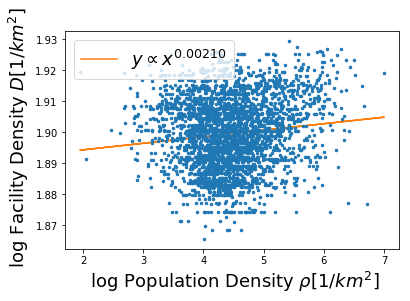

In [85]:
def county_lookup(county,gender="Female"):
    m = re.split(r' County',county)
    try:
        return life_expectancy[ m[0] == life_expectancy['County']][gender+' life expectancy, 2010 (years)'].values[0]
    except:
        pass
def life_expectancy_array(array):
    county = []
    life = []
    pop = []
    for i,x in enumerate(array):
        y = county_lookup(x)
        if y:
            county.append(x)
            life.append(y)
            
            pop.append(float(census_counties[census_counties["GEO.display-label"]==x]['respop72016'].values[0]))
    return pop,county,life
        
'''        
print(census_counties["GEO.display-label"][67])
for i,x in enumerate(census_counties["GEO.display-label"][1:66]):
    y = county_lookup(x)
'''

#Male_life_exp = list(map(county_lookup, census_counties["GEO.display-label"][1:66]))
counties = census_counties["GEO.display-label"]


pop,county,life = life_expectancy_array(counties)



logx = np.log10(pop)
logy = np.log10(life)

a2,a2_cov = curve_fit(power_func,logx,logy,p0=(11.1,1.1))
print(a2)

plt.plot( logx,logy,'.',ms=5)
plt.plot(logx,power_func(logx,*a2),label = r'$y \propto x^{%.5f}$'%(a2[1]),zorder=0)
plt.legend(loc =2,fontsize = 18)
plt.xlabel(r' log Population Density $\rho [1/km^2]$',fontsize=18)
plt.ylabel(r' log Facility Density $D [1/km^2]$',fontsize=18)

plt.show()

In [49]:
pop[1][0]

'208563'

In [4]:

for i in range(colleges["Institution_Zip"].values):
    colleges["Institution_Zip"].values[i][0:5]

NameError: name 'colleges' is not defined

In [63]:
data = pd.read_csv("data/Census/ACS_16_5YR_DP03+lat_lon.csv")
colleges = pd.read_csv("data/colleges/Accreditation_04_2017.csv")
hospitals = pd.read_csv("data/Hospitals.csv")


In [64]:
def get_area(geom):
    s = shape(geom)
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
                   pyproj.Proj(init='epsg:3857'))

    s_new = transform(proj, s)

    projected_area = transform(proj, s).area
    return projected_area/10000000

def power_func(x,*a):
    '''power function.'''
    return a[0]+x*a[1]

def find_n_c2(lat_long,pop,facility):
    '''compute population in the voronoi cell of each facility and return an array'''
    
    n=0
    voronoi_kdtree = cKDTree(facility) #computes ckdtree
    
    # distance, and region
    test_point_dist, test_point_regions = voronoi_kdtree.query(lat_long, k=1) 
    
    
    # compute number of people in cell
    bin_pop = np.ones(len(facility),dtype = int)
    
    # population from each zip to each facility
    print(len(lat_long))
    print(len(pop))
    print(len(facility))

    for i in range(len(lat_long)-1):
        if test_point_regions[i]!= len(facility):
            bin_pop[test_point_regions[i]]+= pop[i]
        
    # compute distance
    bin_distance = np.zeros(len(pop))
    
    # total distance
    for i in range(len(pop)):
        bin_distance[test_point_regions[i]]+= test_point_dist[i]*pop[i]
    
    n = np.sum(bin_pop)
    c = np.sum(bin_distance)
    return bin_pop ,bin_distance, test_point_regions,n,c

def plot_scaling(hospitals,data,ax,title):
    '''plots scaling relationships given facilities, population, and plot axes'''
    
    points = np.column_stack((hospitals["X"],hospitals["Y"]))
    
    points = np.unique(points,axis=0)
    
    
    ################################################
    logging.basicConfig(level=logging.INFO)
    geovoronoi_log = logging.getLogger('geovoronoi')
    geovoronoi_log.setLevel(logging.INFO)
    geovoronoi_log.propagate = True

    COUNTRY = 'United States'

    print('loading country `%s` from naturalearth_lowres' % COUNTRY)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    area = world[world.name == COUNTRY]
    assert len(area) == 1

    print('CRS:', area.crs)   # gives epsg:4326 -> WGS 84
    coords=points

    area_shape = area.iloc[0].geometry   # get the Polygon
    pts = [p for p in coords_to_points(coords) if p.within(area_shape)]
    coords = points_to_coords(pts)
    del pts

    poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, area_shape,return_unassigned_points=False)
    poly_areas = calculate_polygon_areas(poly_shapes, m2_to_km2=True)
    
    fig, ax1 = subplot_for_map(show_x_axis=False, show_y_axis=False,figsize=(30,40))
    plot_voronoi_polys_with_points_in_area(ax1, area_shape, poly_shapes, coords, poly_to_pt_assignments)
    ax1.set_title(str(len(pts)),fontsize = 32)

    ################################################
    
    population = np.column_stack((data['lon'],data['lat']))
    
    poly_areas = calculate_polygon_areas(poly_shapes, m2_to_km2=False)
    areas= [get_area(i) for i in poly_shapes]
    
    new_points = np.zeros((len(pts),2))

    for i,j in enumerate(pts):
        new_points[i,0] =j.x
        new_points[i,1] = j.y
            
    bin_pop,bin_distance,test_point_regions,n,c = find_n_c2(population,data["HC01_VC03"].values,new_points)
   
    newbin=bin_pop[bin_pop !=1]
    areas = np.array(areas)
    newareas = areas[bin_pop !=1]
            
    logx = np.log10(newbin/newareas)
    logy = np.log10(1/newareas)

    a2,a2_cov = curve_fit(power_func,logx,logy,p0=(11.1,1))
    

    ax.plot( logx,logy,'.',ms=5)
    ax.plot(logx,logx-5,label=r"$y\propto x^{1.00}$")
    ax.plot(logx,power_func(logx,*a2),label = r'$y \propto x^{%.2f}$'%(a2[1]),zorder=0)
    ax.set_xlim([-2,9])
    ax.set_ylim([-7,4])
    ax.set_title(title)
    ax.legend(loc =2,fontsize = 18)
    ax.set_xlabel(r' log Population Density $\rho [1/km^2]$',fontsize=18)
    ax.set_ylabel(r' log Facility Density $D [1/km^2]$',fontsize=18)

In [65]:
option_key='NAICS_DESC'
options = list(set([i for i in hospitals[option_key]]))


"""
options.pop(0)
options.pop(1)
options.pop(1)
options.pop(1)

options.pop(1)

options.pop(1)

options.pop(4)
options.pop(5)
options.pop(5)
options.pop(5)"""

# for TYPE 4 columns
#options.pop(-3)
#options.pop(-2)
print(options)
print(len(options))


['CHRONIC DISEASE HOSPITALS', 'HOSPITALS, ADDICTION', 'PHYSICAL REHABILITATION HOSPITALS', 'MENTAL HEALTH HOSPITALS', "CHILDREN'S HOSPITALS, SPECIALTY (EXCEPT PSYCHIATRIC, SUBSTANCE ABUSE)", 'HOSPITALS, SUBSTANCE ABUSE', 'ORTHOPEDIC HOSPITALS', "CHILDREN'S HOSPITALS, PSYCHIATRIC OR SUBSTANCE ABUSE", 'HOSPITALS, SPECIALTY (EXCEPT PSYCHIATRIC, SUBSTANCE ABUSE)', 'EYE, EAR, NOSE, AND THROAT HOSPITALS', 'CANCER HOSPITALS', 'HOSPITALS, PSYCHIATRIC PEDIATRIC', 'HOSPITALS, PSYCHIATRIC (EXCEPT CONVALESCENT)', 'GENERAL MEDICAL AND SURGICAL HOSPITALS', 'REHABILITATION HOSPITALS (EXCEPT ALCOHOLISM, DRUG ADDICTION)', "CHILDREN'S HOSPITALS, GENERAL", 'MATERNITY HOSPITALS', 'EXTENDED CARE HOSPITALS (EXCEPT MENTAL, SUBSTANCE ABUSE)']
18


In [66]:
options[5]


'HOSPITALS, SUBSTANCE ABUSE'

6
CHRONIC DISEASE HOSPITALS


INFO:geovoronoi:running Voronoi tesselation for 1 points
INFO:geovoronoi:running Voronoi tesselation for 11 points
INFO:geovoronoi:generated 11 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:running Voronoi tesselation for 1 points
INFO:geovoronoi:running Voronoi tesselation for 4 points
INFO:geovoronoi:generated 4 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:shapely.geos:Self-intersection at or near point -62.033151826342738 -67.287629571321929
INFO:shapely.geos:Self-intersection at or near point -62.033151826342738 -67.287629571321929
INFO:geovoronoi:running Voronoi tesselation for 21 points
INFO:geovoronoi:generated 21 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:running Voronoi tesselation for 12 points
INFO:geovoronoi:generated 12 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:shapely.geos:Self-intersection at or near point -46.535421901100101 -42.576394922682574
I

loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
HOSPITALS, ADDICTION
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
PHYSICAL REHABILITATION HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
MENTAL HEALTH HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
CHILDREN'S HOSPITALS, SPECIALTY (EXCEPT PSYCHIATRIC, SUBSTANCE ABUSE)
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
HOSPITALS, SUBSTANCE ABUSE
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
ORTHOPEDIC HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
CHILDREN'S HOSPITALS, PSYCHIATRIC OR SUBSTANCE ABUSE
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
HOSPITALS, SPECIALTY (EXCEPT PSYCHIATRIC, SUBSTANCE ABUSE)
loading country `Un

INFO:geovoronoi:running Voronoi tesselation for 107 points
INFO:geovoronoi:generated 107 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 107 points to 107 Voronoi polygons
INFO:geovoronoi:running Voronoi tesselation for 1 points
INFO:geovoronoi:running Voronoi tesselation for 4 points
INFO:geovoronoi:generated 4 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:shapely.geos:Self-intersection at or near point -50.054452926363403 -96.051652047233702
INFO:shapely.geos:Self-intersection at or near point -50.054452926363403 -96.051652047233702
INFO:geovoronoi:running Voronoi tesselation for 2 points


33120
33120
107
EYE, EAR, NOSE, AND THROAT HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
CANCER HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
HOSPITALS, PSYCHIATRIC PEDIATRIC
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
HOSPITALS, PSYCHIATRIC (EXCEPT CONVALESCENT)
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 560 points
INFO:geovoronoi:generated 560 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 560 points to 560 Voronoi polygons


33120
33120
560
GENERAL MEDICAL AND SURGICAL HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 5832 points
INFO:geovoronoi:generated 5832 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 5832 points to 5832 Voronoi polygons


33120
33120
5832
REHABILITATION HOSPITALS (EXCEPT ALCOHOLISM, DRUG ADDICTION)
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 318 points
INFO:geovoronoi:generated 318 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 318 points to 318 Voronoi polygons
INFO:geovoronoi:running Voronoi tesselation for 82 points
INFO:geovoronoi:generated 82 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 82 points to 82 Voronoi polygons


33120
33120
318
CHILDREN'S HOSPITALS, GENERAL
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 3 points
INFO:geovoronoi:generated 3 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines


33120
33120
82
MATERNITY HOSPITALS
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}
EXTENDED CARE HOSPITALS (EXCEPT MENTAL, SUBSTANCE ABUSE)
loading country `United States` from naturalearth_lowres
CRS: {'init': 'epsg:4326'}


INFO:geovoronoi:running Voronoi tesselation for 351 points
INFO:geovoronoi:generated 351 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 351 points to 351 Voronoi polygons


33120
33120
351


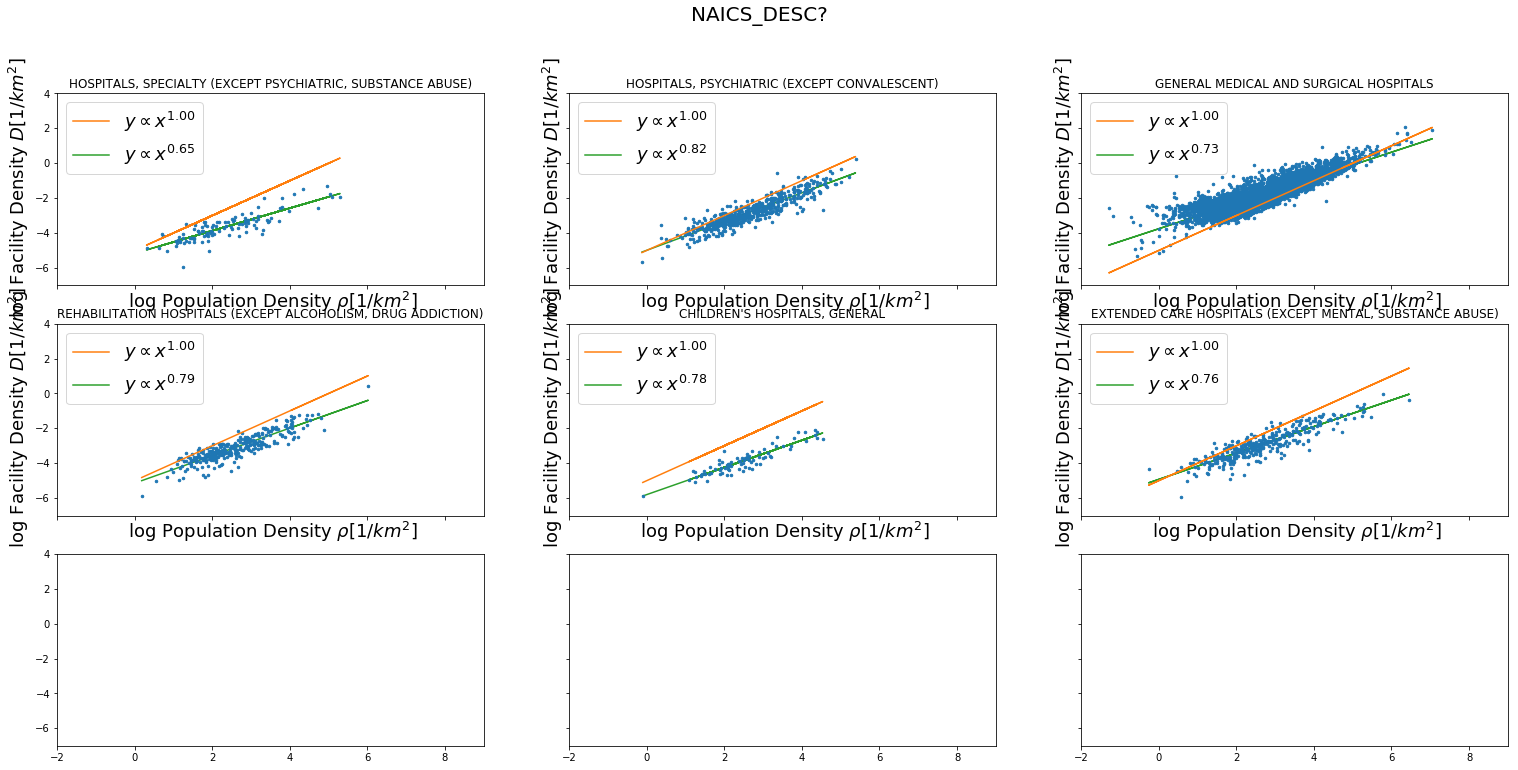

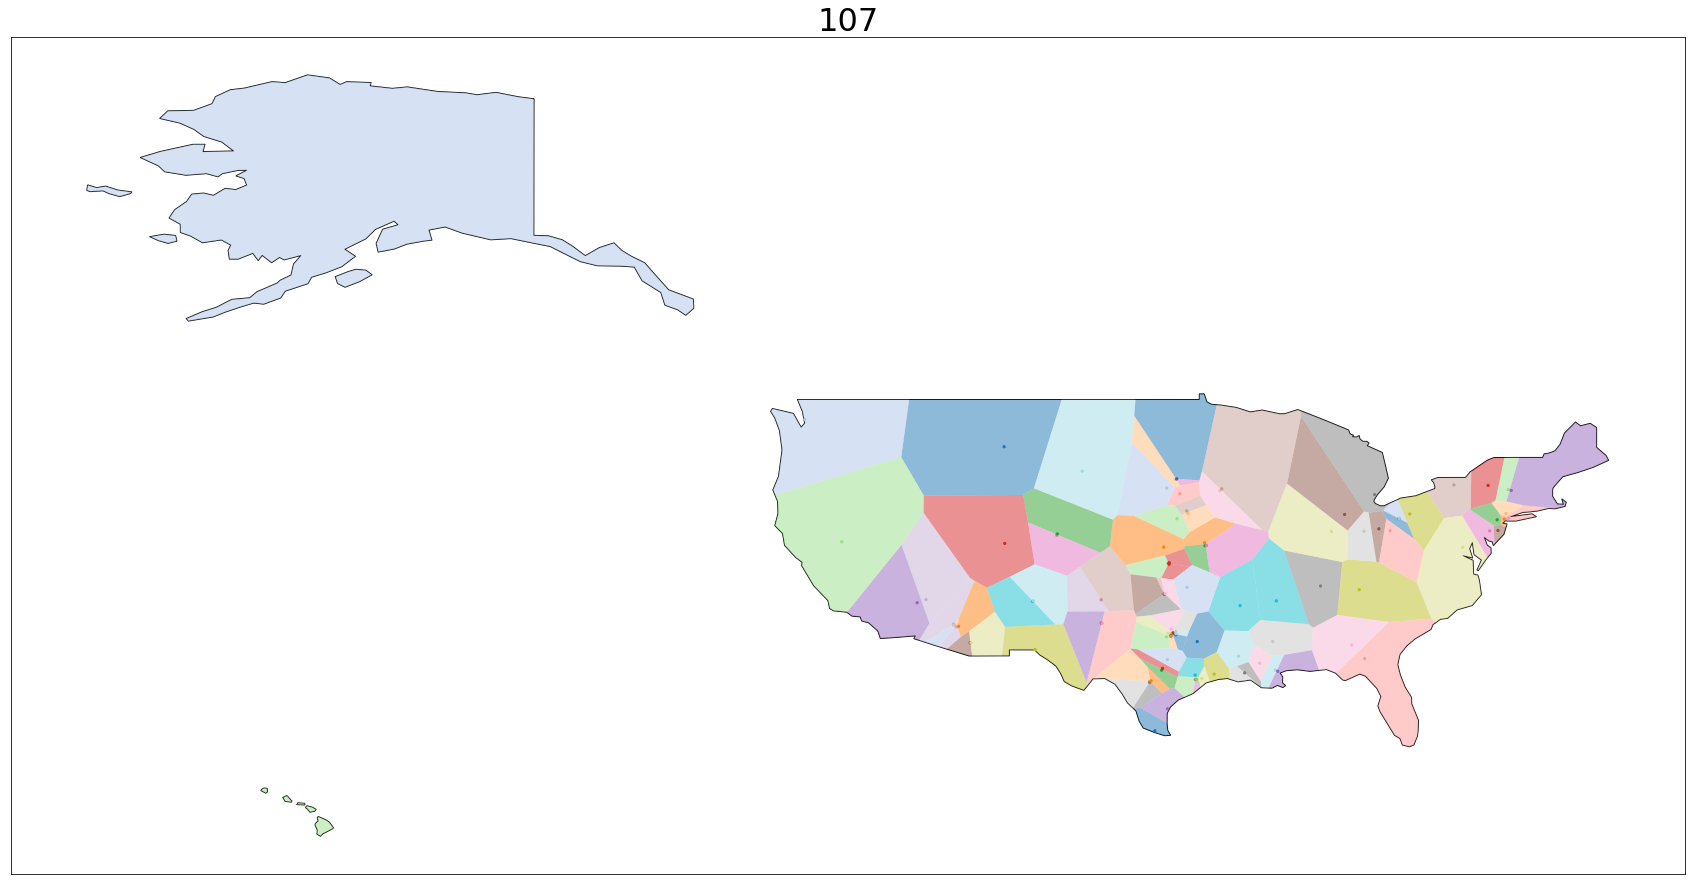

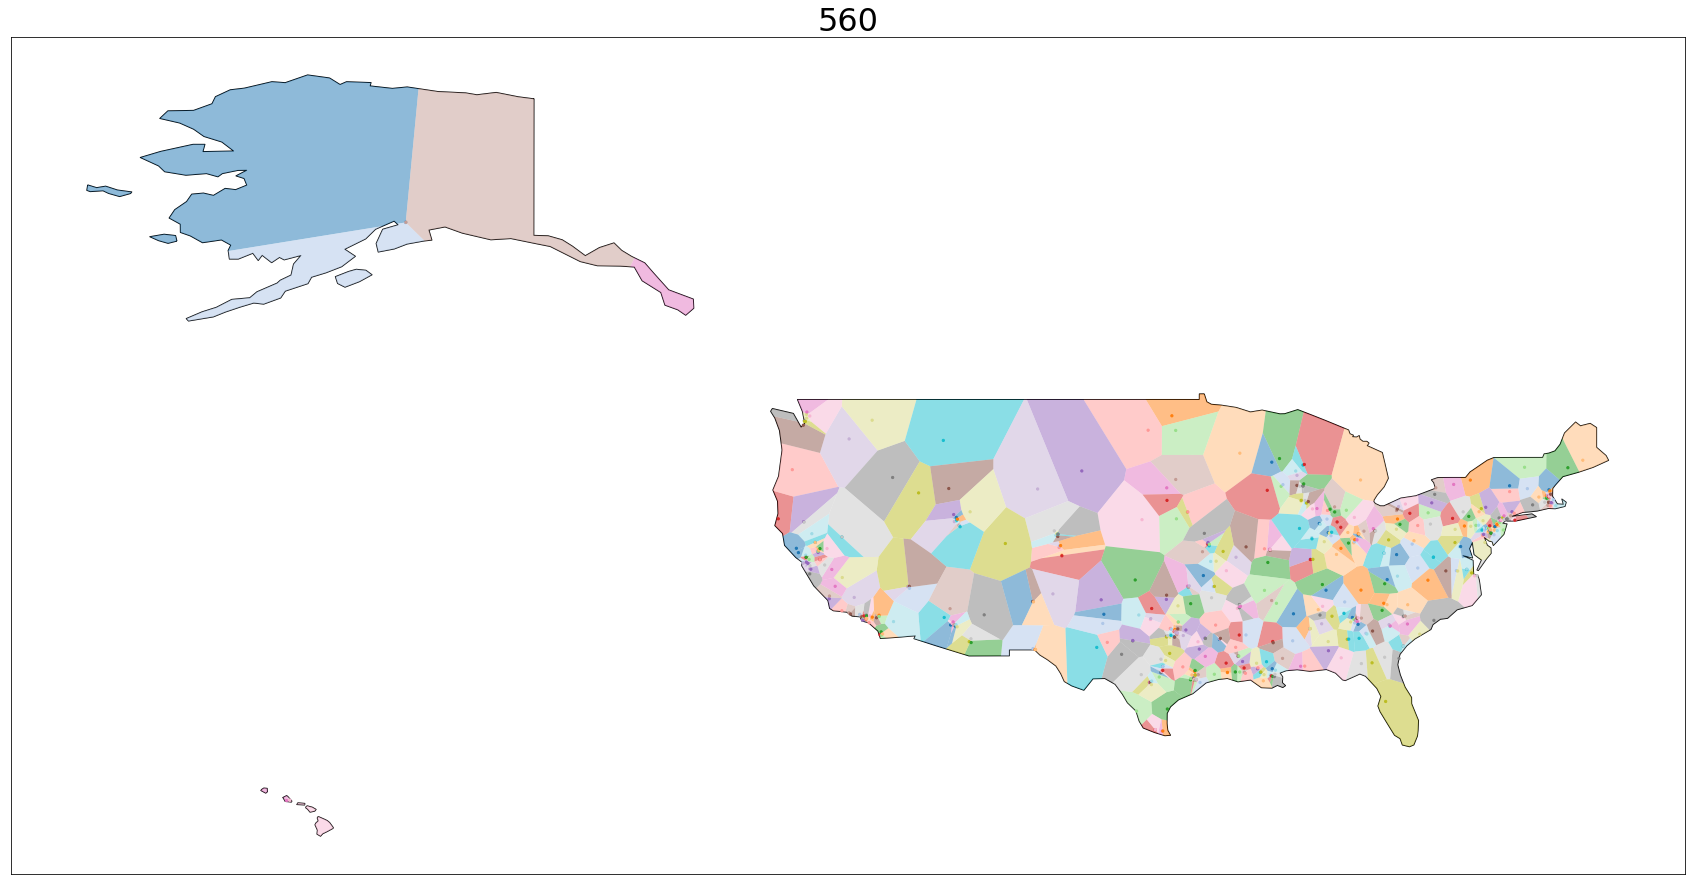

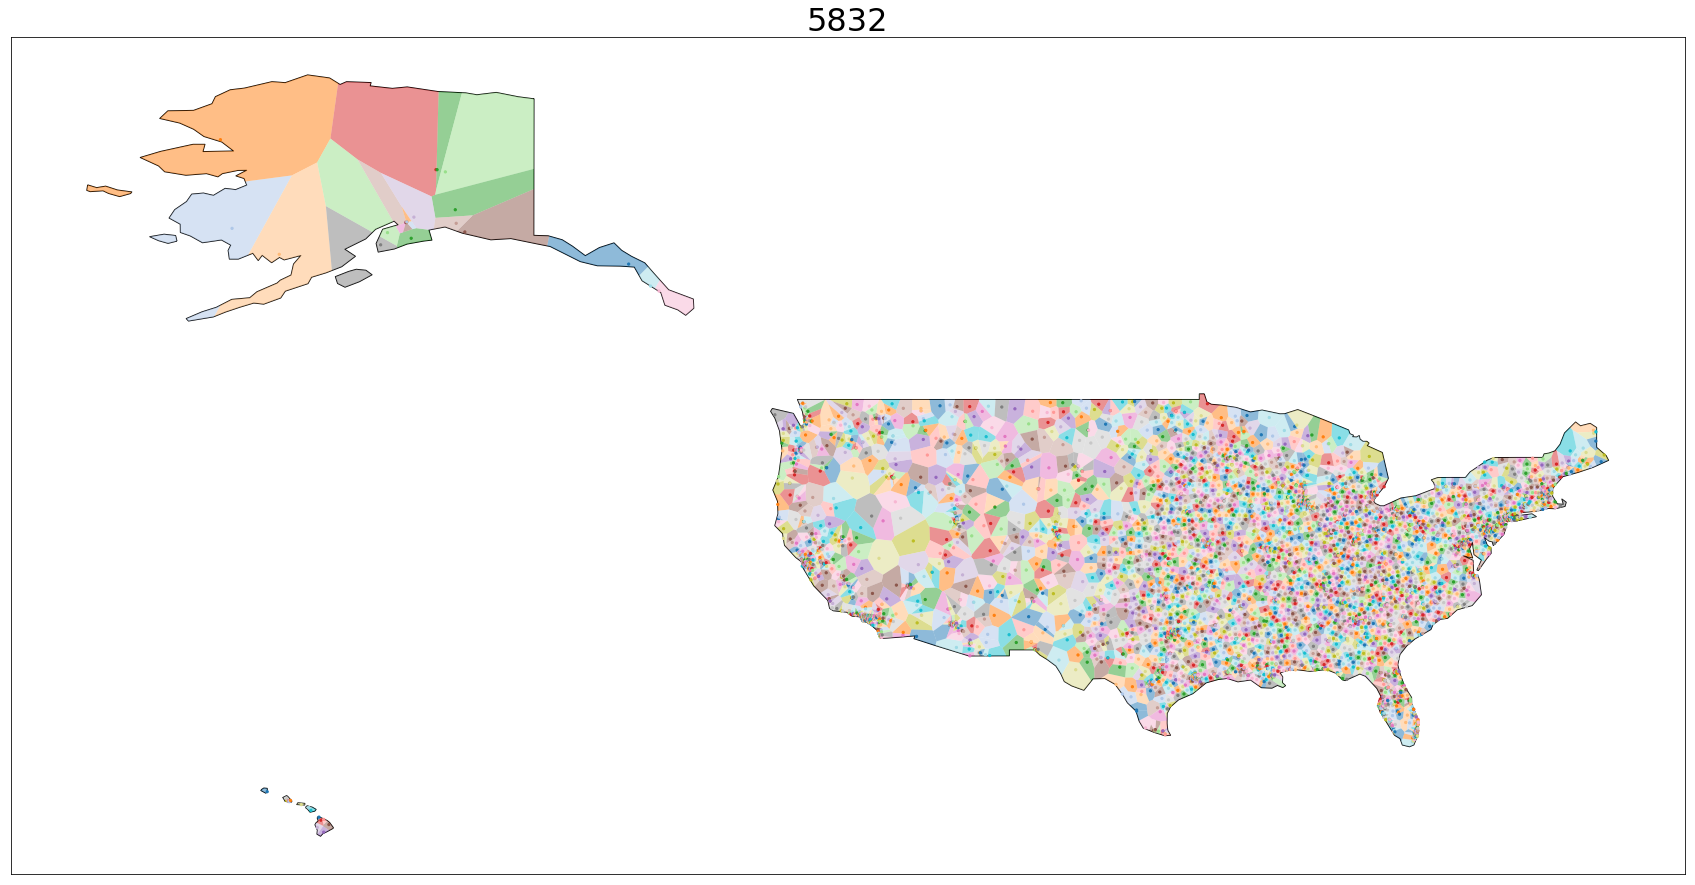

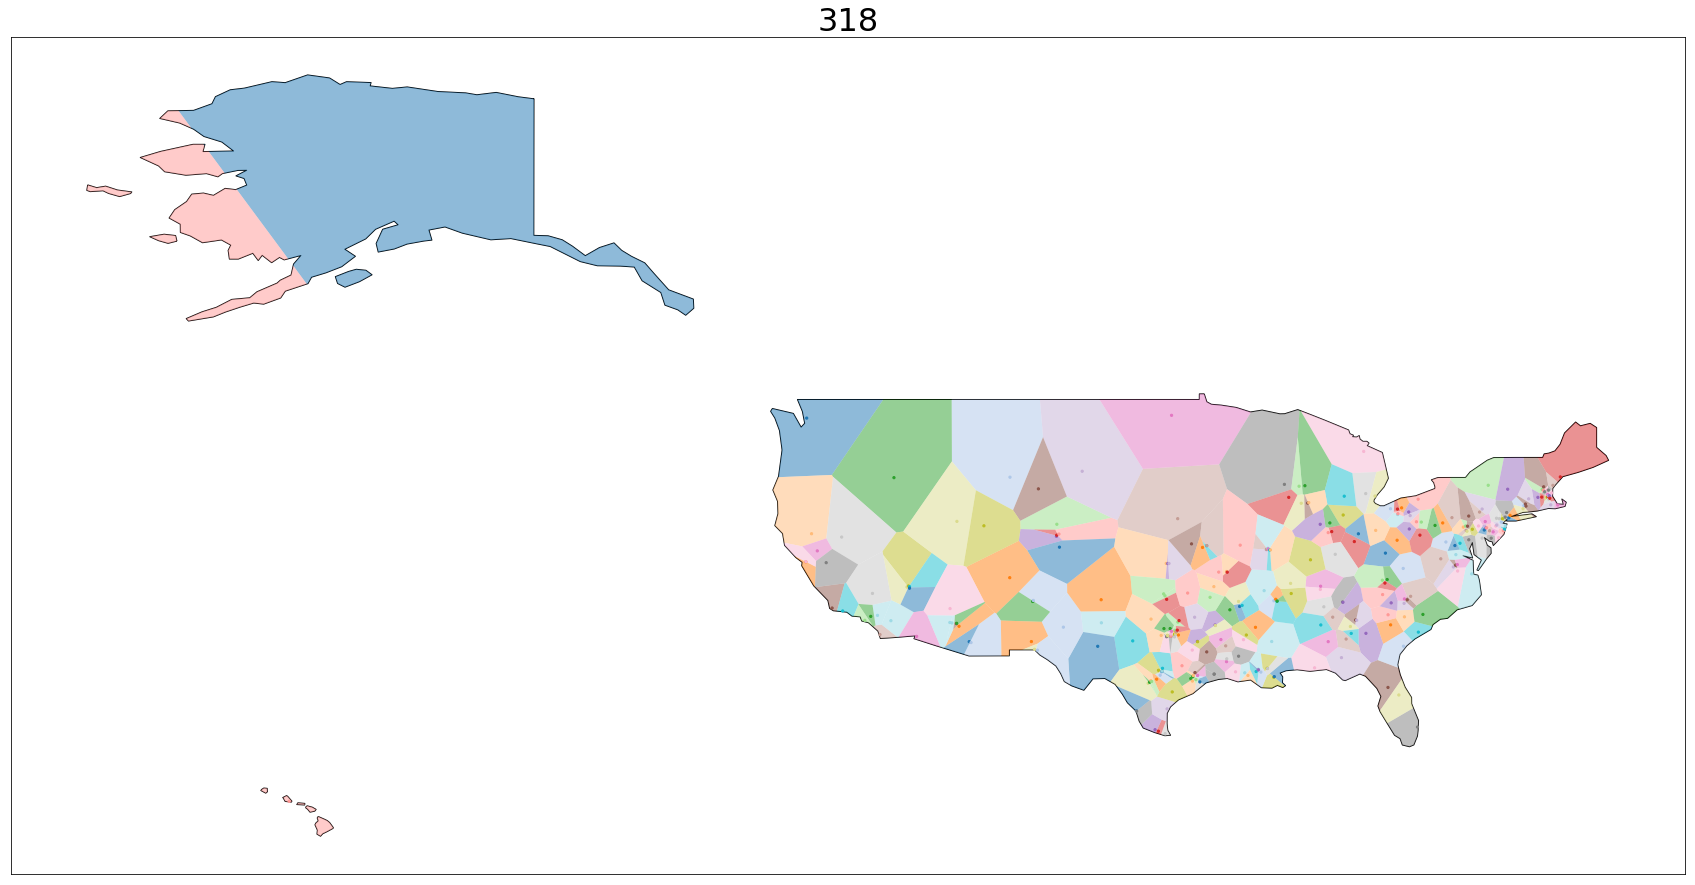

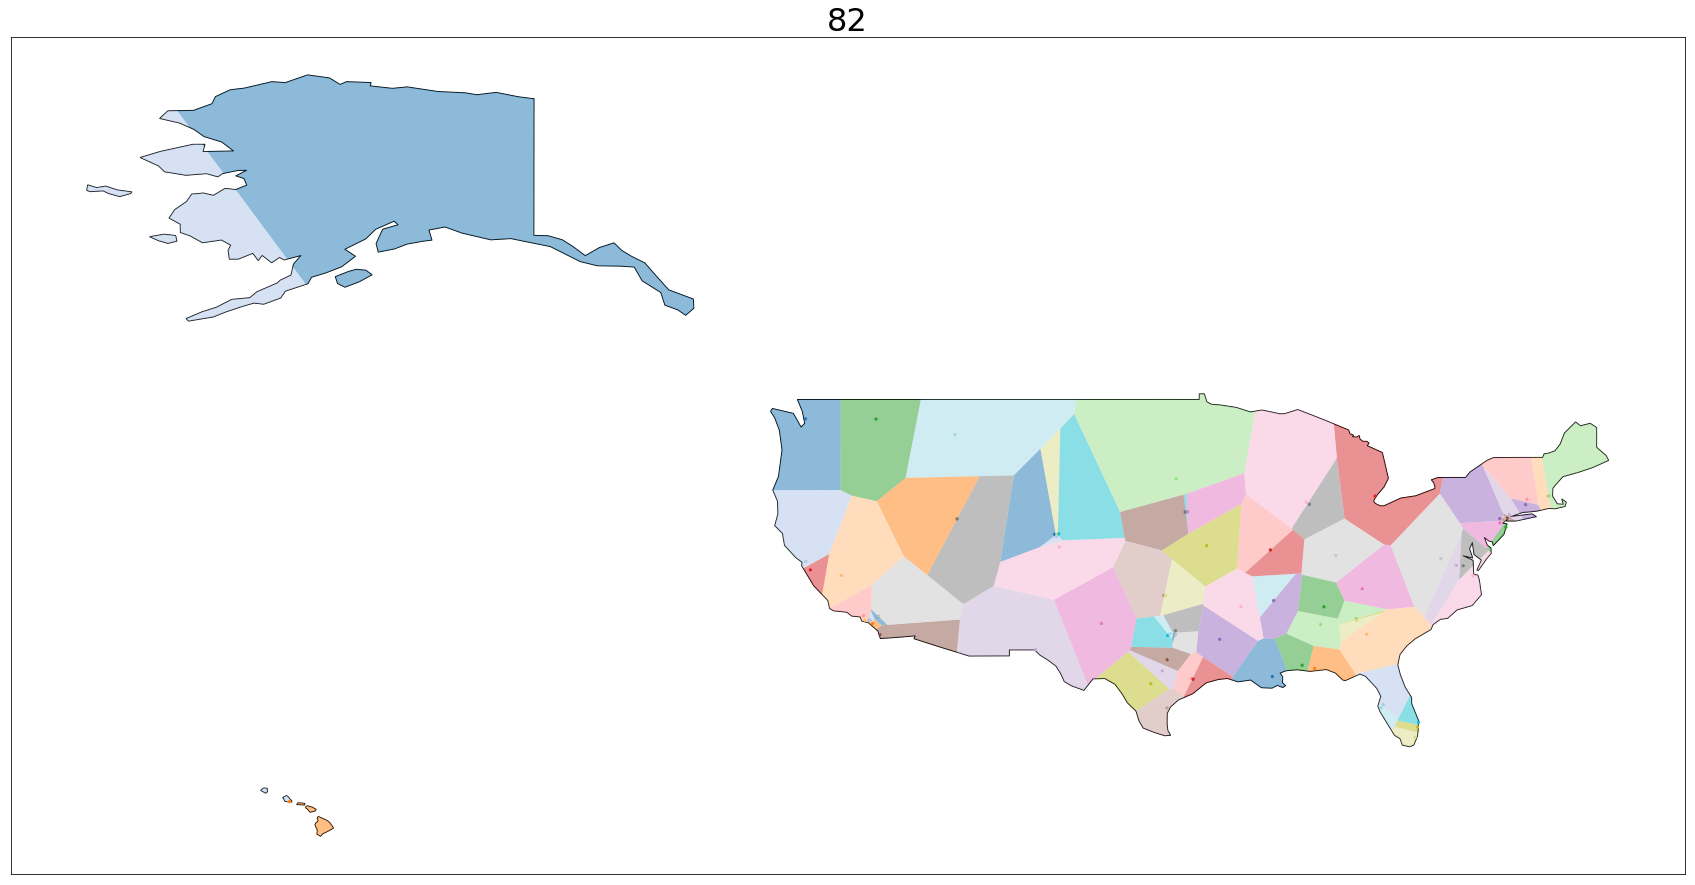

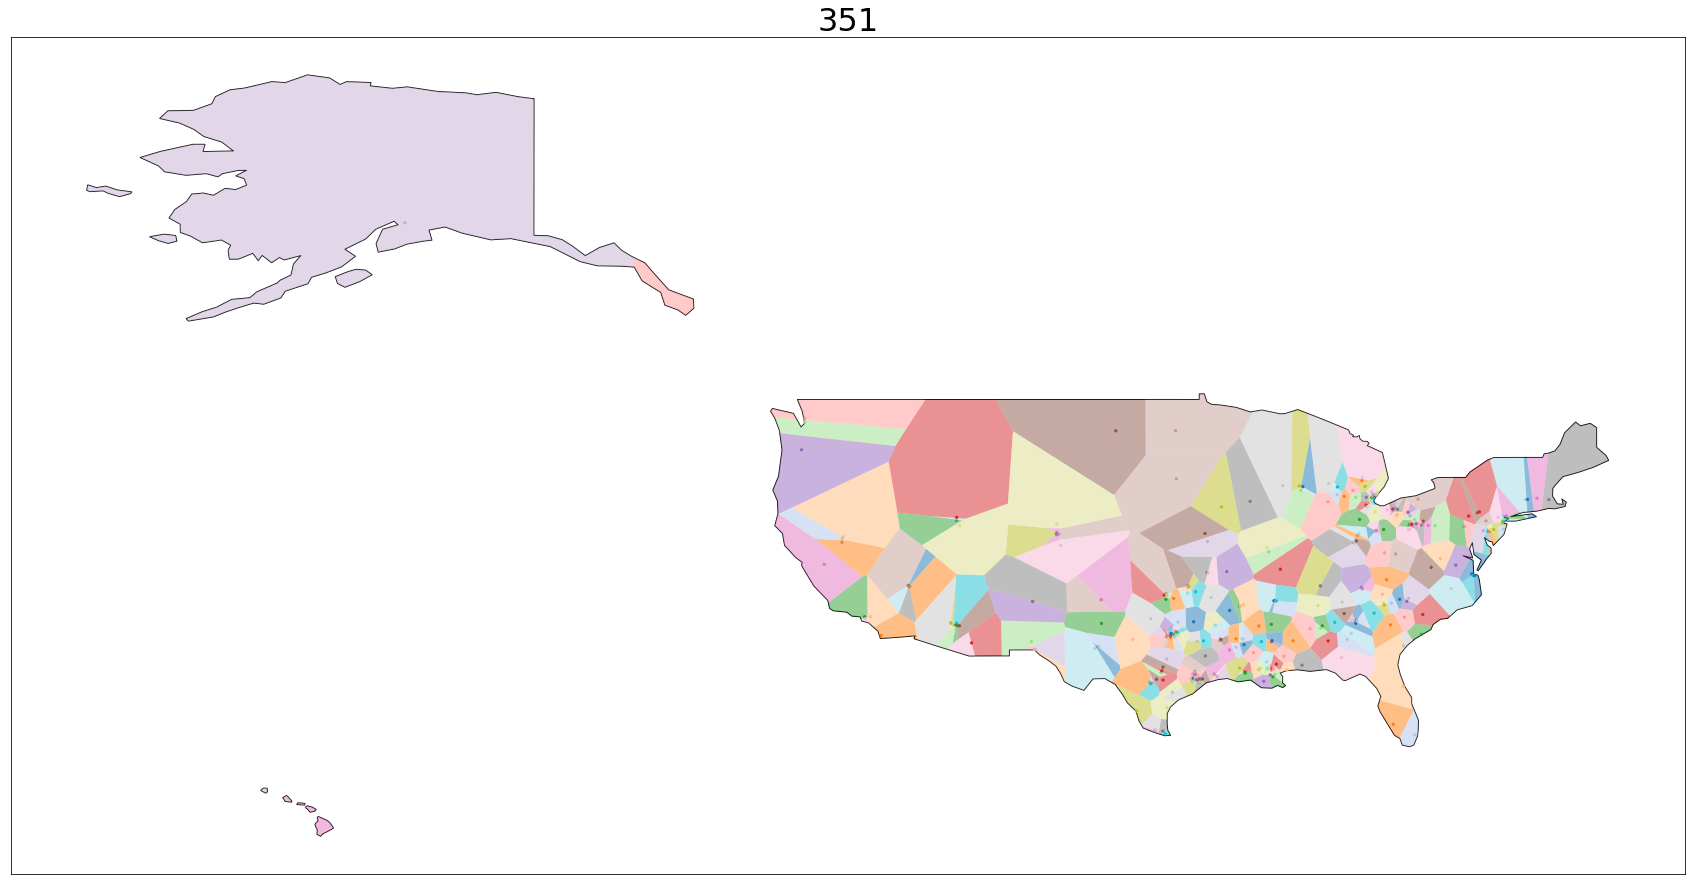

In [67]:
numplots =len(options)
numplots =6
print(numplots)
columns =3
fig,ax = plt.subplots(numplots//columns+1,columns, sharex=True, sharey=True,figsize = (26,6*numplots//columns))
ax=ax.ravel()
title=["SPECIALITY","PSYCHIATRIC AND SUBSTANCE","GENERAL"]
#hospitals = hospitals[hospitals['HELIPAD']=="N"]
count = 0
for i,x in enumerate(options):
    hospital = hospitals[hospitals[option_key]==x]
    print(x)
    try:
        plot_scaling(hospital,data,ax[count],x)
        count += 1
    except:
        pass
fig.suptitle(option_key+"?",fontsize=20)
plt.show()